## In this tutorial we create a CNN and dataloaders, and train / prune the model.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
keras.backend.set_image_data_format("channels_first")

2025-07-09 15:22:54.732414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752067374.751299  879899 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752067374.757088  879899 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752067374.771854  879899 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752067374.771874  879899 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752067374.771876  879899 computation_placer.cc:177] computation placer alr

In [25]:
try:
    os.chdir("/home/das214/PQuant/mdmm_dev/src")
except:
    pass

for f in os.listdir(os.getcwd()):
    print(f)

pquant


In [17]:
from keras.layers import Dense, SeparableConv2D, Conv2D, AveragePooling2D, Flatten, Input, Activation
from keras.models import Model

def var_network(var, hidden, output):
    var = Flatten()(var)
    var = Dense(hidden)(var)
    var = Activation("tanh")(var)
    var = Dense(hidden)(var)
    var = Activation("tanh")(var)
    return Dense(output)(var)

def conv_network(var, n_filters, kernel_size):
    var = SeparableConv2D(n_filters,kernel_size)(var)
    var = Activation("tanh")(var)
    var = Conv2D(n_filters,1)(var)
    var = Activation("tanh")(var)    
    return var

def CreateModel(shape, n_filters, kernel_size, pool_size, hidden, output):
    x_base = x_in = Input(shape)
    stack = conv_network(x_base,  n_filters, kernel_size)
    stack = AveragePooling2D(
        pool_size=(pool_size, pool_size), 
        strides=None, 
        padding="valid", 
        data_format=None,        
    )(stack)
    stack = Activation("tanh")(stack)
    stack = var_network(stack, hidden=16, output=output)
    model = Model(inputs=x_in, outputs=stack)
    return model

In [21]:
model=CreateModel(shape = (2,16,16), 
                  n_filters=5, kernel_size=3,
                  pool_size=3, 
                  hidden=10,
                  output = 14)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 2, 16, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_6              │ (None, 5, 14, 14)      │            33 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_26 (Activation)      │ (None, 5, 14, 14)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 14, 14)      │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_27 (Activation)      │ (None, 5, 14, 14)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 5, 4, 4)        │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_28 (Activation)      │ (None, 5, 4, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_29 (Activation)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_30 (Activation)      │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 14)             │           238 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,869 (7.30 KB)

 Trainable params: 1,869 (7.30 KB)

 Non-trainable params: 0 (0.00 B)

## Add pruning and quantization
To add pruning and quantization, we need a config file that defines how to do that. Let's load a config file from pquant/configs/configs_pdp.yaml. The training function we use later will add the pruning layers and quantized activations automatically using this config

In [26]:
from pquant import get_default_config
from IPython.display import JSON

# pruning_methods: "autosparse, cl, cs, dst, pdp, wanda, mdmm"
pruning_method = "mdmm"
config = get_default_config(pruning_method)
JSON(config)

<IPython.core.display.JSON object>

In [ ]:
# Replace layers with compressed layers
from pquant import add_compression_layers
input_shape = (1, 16, 16, 2)
model = add_compression_layers(model, config, input_shape)
model

ResNet(
  (conv1): CompressedLayerConv2d(
    (pruning_layer): <MDMM name=mdmm, built=True>
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_1, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_2, built=True>
      )
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): CompressedLayerConv2d(
        (pruning_layer): <MDMM name=mdmm_3, built=True>
      )
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (r

## Pruning and quantization in the config
From the config we see that we are using the PDP pruning method, unstructured version. We aim for 80% weights pruned (sparsity 0.8), and we quantize the model to 8 bits (1 bit goes to sign). 
By default, all convolutional and linear layers, as well as activations will be quantized using the default values ```default_integer_bits``` and ```default_fractional_bits```. Similarly, by default all convolutional and linear layers will be pruned.

We can disable pruning and/or quantization by setting the enable_pruning / enable_quantization to False. To change quantization bits for a specific layer, add the layers name to the list found in ```layer_specific```, followed by number of bits. To disable pruning for a single layer, add its name to the ```disable_pruning_for_layers``` list. 

We'll show later how to create a custom quantization / pruning config file from an existing config for a given model

## About the different epochs

The config defines 20 ```pretraining_epochs```, 100 ```epochs``` and 20 ```fine_tuning_epochs```. What happens during each of these training steps is algorithm specific. 

In PDP, the pretraining phase consists of training without pruning, followed by calculation of layerwise pruning budgets. After pretraining is finished and the layerwise pruning budgets have been calculated, the training with pruning begins. The mask during this training is a soft mask, consisting of values ranging between (and including) 0 and 1. 

The fine-tuning step in PDP is optional (not mentioned in the original paper), and during it the mask is fixed and rounded to 0s and 1s.

## Create data set
#### Let's create the data loader and the training and validation loops

In [7]:
import torchvision.transforms as transforms

def get_cifar10_data(batch_size):
    normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomCrop(32, padding=4), 
                                          transforms.ToTensor(), normalize])
    test_transform = transforms.Compose([transforms.ToTensor(), normalize])  
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
    valset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=test_transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader

from quantizers.fixed_point.fixed_point_ops import get_fixed_quantizer
# Set up input quantizer
quantizer = get_fixed_quantizer(overflow_mode="SAT")


def train_resnet(model, trainloader, device, loss_func, epoch, optimizer, scheduler, *args, **kwargs):
    first_batch = True
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.)) # 8 bits input quantization
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        losses = get_model_losses(model, torch.tensor(0.).to(device))
        loss += losses
        loss.backward()
        
        if first_batch:
            print("\n ---- Checking Loss values ----")
            print("Loss:", loss_func(outputs, labels).item())
            print("Model Losses:", losses.item())
            print("--------------------------------------------------")
            print(f"\n--- Checking Gradients for lmbda at Epoch {epoch} ---")
            for name, module in model.named_modules():
                if "pruning_layer.constraint_layer.module" in name and hasattr(module, "lmbda"):
                    # Access the underlying tensor via the '.value' attribute
                    underlying_tensor = module.lmbda.value
                    grad_value = underlying_tensor.grad
                    print(f"Layer: {name}, lmbda: {underlying_tensor.item()}")
                    if grad_value is not None:
                        print(f"Layer: {name}, Gradient: {grad_value.item()}")
                    else:
                        print(f"Layer: {name}, Gradient: None")
                        
                    break
            print("--------------------------------------------------\n")
            first_batch = False
            
        optimizer.step()
        epoch += 1
        if scheduler is not None:
            scheduler.step()


from pquant import get_layer_keep_ratio, get_model_losses

def validate_resnet(model, testloader, device, loss_func, epoch, *args, **kwargs):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = quantizer(inputs, k=torch.tensor(1.), i=torch.tensor(0.), f=torch.tensor(7.)) # 8 bits input quantization
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        ratio = get_layer_keep_ratio(model)
        print(f'Accuracy: {100 * correct / total:.2f}%, remaining_weights: {ratio * 100:.2f}%')

BATCH_SIZE = 256
train_loader, val_loader = get_cifar10_data(BATCH_SIZE)

100%|██████████| 170498071/170498071 [00:03<00:00, 46302039.64it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Create loss function, scheduler and optimizer

In [8]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0001, momentum=0.9)
scheduler = CosineAnnealingLR(optimizer, 200)
loss_function = nn.CrossEntropyLoss()

## Train model
Training time. We use the train_compressed_model function from pquant to train. We need to provide some parameters such as training and validation functions, their input parameters, the model and the config file. The function automatically adds pruning layers and replaces activations with a quantized variant, trains the model, and removes the pruning layers after training is done

In [9]:
from pquant import iterative_train
"""
Inputs to train_resnet we defined previously are:
          model, trainloader, device, loss_func, epoch, optimizer, scheduler, **kwargs
"""

trained_model = iterative_train(model = model, 
                                config = config, 
                                train_func = train_resnet, 
                                valid_func = validate_resnet, 
                                trainloader = train_loader, 
                                testloader = val_loader, 
                                device = device, 
                                loss_func = loss_function,
                                optimizer = optimizer, 
                                scheduler = scheduler
                                )


 ---- Checking Loss values ----
Loss: 7.381867408752441
Model Losses: 6.1617112159729
--------------------------------------------------

--- Checking Gradients for lmbda at Epoch 0 ---
Layer: conv1.pruning_layer.constraint_layer.module, lmbda: 1.0016350746154785
Layer: conv1.pruning_layer.constraint_layer.module, Gradient: None
--------------------------------------------------

Accuracy: 48.45%, remaining_weights: 96.31%

 ---- Checking Loss values ----
Loss: 1.4272035360336304
Model Losses: 13.90738296508789
--------------------------------------------------

--- Checking Gradients for lmbda at Epoch 197 ---
Layer: conv1.pruning_layer.constraint_layer.module, lmbda: 1.692549705505371
Layer: conv1.pruning_layer.constraint_layer.module, Gradient: None
--------------------------------------------------

Accuracy: 46.08%, remaining_weights: 95.79%

 ---- Checking Loss values ----
Loss: 1.3812137842178345
Model Losses: 17.715513229370117
-------------------------------------------------

In [10]:
#print layers and lmbda weights in the model

for name, layer in model.named_modules():
    if hasattr(layer, "lmbda"):
        print(f"Layer: {name}, lmbda: {layer.lmbda}")
   

Layer: conv1.pruning_layer.constraint_layer.module, lmbda: <Variable path=mdmm/equality_constraint/equality_constraint_lmbda, shape=(), dtype=float32, value=0.0>
Layer: layer1.0.conv1.pruning_layer.constraint_layer.module, lmbda: <Variable path=mdmm_1/equality_constraint_1/equality_constraint_1_lmbda, shape=(), dtype=float32, value=0.0>
Layer: layer1.0.conv2.pruning_layer.constraint_layer.module, lmbda: <Variable path=mdmm_2/equality_constraint_2/equality_constraint_2_lmbda, shape=(), dtype=float32, value=0.0>
Layer: layer1.1.conv1.pruning_layer.constraint_layer.module, lmbda: <Variable path=mdmm_3/equality_constraint_3/equality_constraint_3_lmbda, shape=(), dtype=float32, value=0.0>
Layer: layer1.1.conv2.pruning_layer.constraint_layer.module, lmbda: <Variable path=mdmm_4/equality_constraint_4/equality_constraint_4_lmbda, shape=(), dtype=float32, value=0.0>
Layer: layer2.0.conv1.pruning_layer.constraint_layer.module, lmbda: <Variable path=mdmm_5/equality_constraint_5/equality_constrain

We see from that with PDP, the number of weights goes down during training, until it reaches the target sparsity (sparsity of 80%, or ~20% remaining weights). The function that calculates the remaining weights feeds the weights through the quantizer and pruning method, and calculates the ratio between non-zero weights and all weights. However, since PDP uses a soft mask during training, the percentage of remaining weights seems to go down rather noisily (can even drop from 80% to ~20% remaining weights). The algorithm actually increases the sparsity linearly.
During fine-tuning the mask is fixed, and turned into a mask of 0s and 1s by a simple rounding operation, so the remaining weights stay the same during each epoch.

In the original paper for PDP there was no fine-tuning after the creation of the final hard mask. We have added fine-tuning here as an option that can be turned off by simply setting ```fine_tuning_epochs``` to 0 in the config file.

/tmp/ipykernel_869604/4156412274.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels(new_ytick)


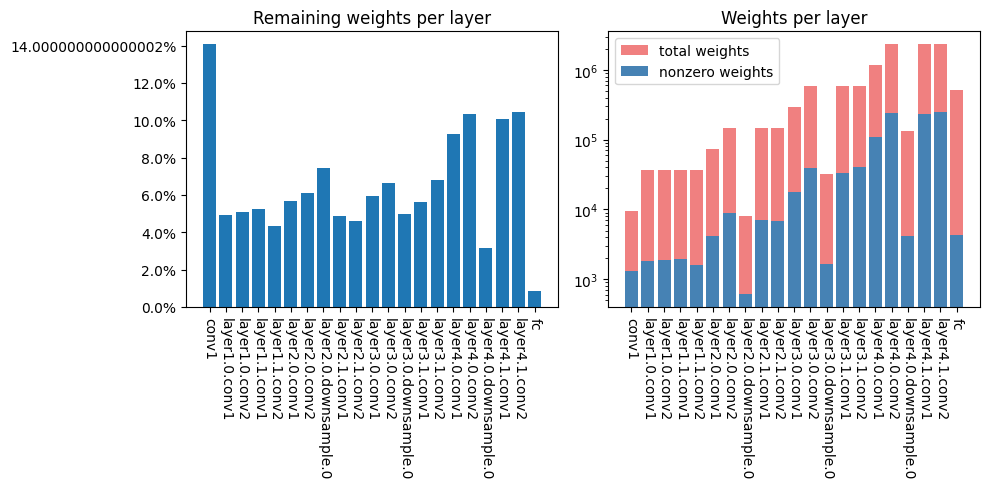

In [14]:
import numpy as np
from pquant import remove_pruning_from_model
import matplotlib.pyplot as plt
# Remove compression layers, leaves Quantized activations in place
model = remove_pruning_from_model(trained_model, config)

# Plot remaining weights
names = []
remaining = []
total_w = []
nonzeros = []
for n, m in trained_model.named_modules():
    if isinstance(m, (torch.nn.Conv1d, torch.nn.Conv2d, torch.nn.Linear)):
        names.append(n)
        nonzero = np.count_nonzero(m.weight.detach().cpu())
        remaining_pct = nonzero / m.weight.numel()
        remaining.append(remaining_pct)
        total_w.append(m.weight.numel())
        nonzeros.append(nonzero)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].bar(range(len(names)), remaining)
ax[0].set_xticks(range(len(names)))
ax[0].set_xticklabels(names)
ax[0].tick_params(axis='x', labelrotation=270)
new_ytick = []
for i in ax[0].get_yticklabels():
    ytick = f"{float(i.get_text()) * 100}%"
    new_ytick.append(ytick)
ax[0].set_yticklabels(new_ytick)
ax[0].title.set_text("Remaining weights per layer")

ax[1].bar(range(len(nonzeros)), total_w, color="lightcoral", label="total weights")
ax[1].bar(range(len(nonzeros)), nonzeros, color="steelblue", label="nonzero weights")
ax[1].set_xticks(range(len(names)))
ax[1].set_xticklabels(names)
ax[1].tick_params(axis='x', labelrotation=270)
ax[1].title.set_text("Weights per layer")
ax[1].legend()
ax[1].set_yscale("log")

plt.tight_layout()
plt.show()

## Custom config from existing config
Using the ```pquant/configs/config_pdp.yaml``` as base, let's customize the quantization and pruning scheme. 

The function we use will go through the model's layers and do the following: 

Quantization:

        1. Looks for the names of convolutional and linear layers, as well as names of the activations (layer type activations and functional types)
        2. Adds the name of the layer to the layer_specific list, along with a default quantization scheme of 0 and 7 for weight and bias (if bias is not None)

Pruning: 

        1. Looks for convolutional and linear layers and adds their name to the disable_pruning_for_layers list.

In [13]:
# Base config
pruning_method = "pdp"
config = get_default_config(pruning_method)
model = torchvision.models.resnet18()


from pquant import add_default_layer_quantization_pruning_to_config
config = add_default_layer_quantization_pruning_to_config(model, config)
config

/depot/cms/conda_envs/das214/pquant-gpu-env/lib/python3.10/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/depot/cms/conda_envs/das214/pquant-gpu-env/lib/python3.10/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/depot/cms/conda_envs/das214/pquant-gpu-env/lib/python3.10/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/depot/cms/conda_envs/das214/pquant-gpu-env/lib/python3.10/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


{'pruning_parameters': {'disable_pruning_for_layers': ['conv1',
   'layer1.0.conv1',
   'layer1.0.conv2',
   'layer1.1.conv1',
   'layer1.1.conv2',
   'layer2.0.conv1',
   'layer2.0.conv2',
   'layer2.0.downsample.0',
   'layer2.1.conv1',
   'layer2.1.conv2',
   'layer3.0.conv1',
   'layer3.0.conv2',
   'layer3.0.downsample.0',
   'layer3.1.conv1',
   'layer3.1.conv2',
   'layer4.0.conv1',
   'layer4.0.conv2',
   'layer4.0.downsample.0',
   'layer4.1.conv1',
   'layer4.1.conv2',
   'fc'],
  'enable_pruning': True,
  'epsilon': 0.015,
  'pruning_method': 'pdp',
  'sparsity': 0.8,
  'temperature': 1e-05,
  'threshold_decay': 0.0,
  'structured_pruning': False},
 'quantization_parameters': {'default_integer_bits': 0.0,
  'default_fractional_bits': 7.0,
  'enable_quantization': True,
  'hgq_gamma': 0.0003,
  'hgq_heterogeneous': True,
  'layer_specific': {'conv1': {'weight': {'integer_bits': 0,
     'fractional_bits': 7}},
   'relu': {'integer_bits': 0, 'fractional_bits': 7},
   'layer1.0.

In [14]:
# Save config
from pquant.core.utils import write_config_to_yaml
write_config_to_yaml(config, "prune_quantize_example.yaml", sort_keys=False)

Now that we have the custom config, it is up to us to modify the quantization bits for each layer that will not use the default value. If a layer uses the default value it can be removed from the ```layer_specific``` list.

For pruning, leave those layers to the ```disable_pruning_for_layers``` list that will not be pruned, others need to be removed from the list.

## About replacing layers and activations
Layers that can currently be compressed: ```nn.Conv1d, nn.Conv2d, nn.Linear```.

Activations that can currently be automatically be replaced with a quantized variant: ```nn.ReLU, nn.Tanh```. The activations are replaced by a quantized variant, found in ```pquant.core.activations_quantizer.py```.

## More about activations
If using layer type activations, note that if you want to keep the fine-grained control over the quantization of the activation, reusing an activation layer can cause problems, as all activations will use the quantization bits set for that particular layer. To avoid this, use a separate ```nn.Tanh``` / ```nn.ReLU``` for each activation

## HGQ
To use HGQ, enable it in the config: `config["quantization_parameters"]["use_high_granularity_quantization"] = True`. Other relevant parameters to tune are `config["quantization_parameters"]["default_integer_bits"]`, `config["quantization_parameters"]["default_fractional_bits"]`, `config["quantization_parameters"]["hgq_gamma"]`.
When using HGQ, we advice using Adam instead of SGD as an optimizer.